# Automated Software Improvement: A Machine Learning Solution
## Second Iteration - Prop Stat Passed
### 2727141 Luke Skinner
### Supervisor: Dr Sandy Brownlee

## Overview

These notebooks contain all the work performed on the second iteration of the Machine Learning model(s) to help guide automated improvement of Software. The dataset provided for this iteration is "merged_stats_sb_17112020_iter2.csv" which is an aggregate of experimental results of edits performed on open source projects. This will include the second cycle of building an effective model. This cycle involved exploring Feature Construction, which used a tool called JavaParser, which allows the ability to parse and intrepret Java Source Files as a tree. This was used to create simple metrics, such as the number of nested if statements in a method. These were then used as new features to attempt to build a predictive model.

#### Imports

In [1]:
import seaborn as sns 
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
import numpy as np
import matplotlib as plt
from scipy.stats import loguniform
import statsmodels.api as sma

#### Utility Functions

In [2]:
def cacl_adj_r2(r2, n, k):
    """
    Calculates the adjusted r2 score based on the following formula:
    Adjusted r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1). This is used to
    complement the original r2 score to give a better understanding of
    how the model explains variance of the predictor variables

    Parameters:
        r2 (float): The original r2 score (from sklearn)
        n (int): The number of observations
        k (int): The number of predictor variables

    Returns:
        adj_r2 (float): The adjusted r2 score 
    """
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

def calc_p_value(X, y):
    X2 = sma.add_constant(X)
    
    return sma.OLS(y, X2)
    

#### Load Dataset

In [3]:
df = pd.read_csv('data/merged_stats_sb_17112020_iter2.csv')

## Proposed Model with JavaParser Metrics 2 - Proportion Stat Passed
## 1. Data Visualisation

In [4]:
df.corrwith(df['PropStatPassed']).drop('PropStatPassed')

MethodIndex                   0.217208
numLines                     -0.042901
numStatements                -0.038476
EditDensity                   0.025152
AveUseDefDist                 0.001108
NotDeclared                   0.046960
AveUseDefDist/MethodLength    0.043212
MedDefUseDist                -0.001371
MedUseDefDist/MethodLength    0.043978
CountLine                     0.012774
CompiledLine                  0.058006
PassedLine                    0.116268
CountStat                     0.012774
CompiledStat                  0.066687
PassedStat                    0.126357
PropLineCompiled              0.358018
PropLinePassed                0.563709
PropStatCompiled              0.754484
cyclomatic                   -0.028330
ncss                         -0.037633
npath                        -0.062924
cyc/length                    0.087491
ncss/length                  -0.045963
npath/length                 -0.068836
InstCoverage-missed           0.028304
InstCoverage-covered     

## 2. Data Preparation

In [5]:
# Lets remove the non numerical fields as they are not useful for the model
df_new = df.drop(['CompositeKey', 'Project', 'MethodName', 'MethodIndex'], axis=1)

df_new.info() 

# We will filter out all rows which have a numLines < 10, we also want to only look at rows with sensible npath & avedefdistuse values
df_new = df_new[(df_new.numLines > 10) & (df.npath > -1)]

df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2157 entries, 0 to 2156
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   numLines                    2157 non-null   int64  
 1   numStatements               2157 non-null   int64  
 2   EditDensity                 2157 non-null   float64
 3   AveUseDefDist               2157 non-null   float64
 4   NotDeclared                 2157 non-null   int64  
 5   AveUseDefDist/MethodLength  2157 non-null   float64
 6   MedDefUseDist               2157 non-null   float64
 7   MedUseDefDist/MethodLength  2157 non-null   float64
 8   CountLine                   2157 non-null   int64  
 9   CompiledLine                2157 non-null   int64  
 10  PassedLine                  2157 non-null   int64  
 11  CountStat                   2157 non-null   int64  
 12  CompiledStat                2157 non-null   int64  
 13  PassedStat                  2157 

## 3. Beginning Train/Test split

##### We now want to identify the features which are most important, we will start by looking at all the other fields with respect to the target. First we will split the data 70%/30%.

In [ ]:
X = df_new.drop(['PropStatPassed'], axis=1)

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

## 4. Feature Importances at a glance

##### To get the feature importances, we will first start by fitting an overall RandomForest model on the data and seeing what it produces as feature importances. This will not be the final model.

#### P Value of X, y

Let's take a look at some statistics, particurlary focusing on the P value. If it is less than 0.05 then we can reject the null hypothesis

In [12]:
p_value = calc_p_value(X, y)

print(p_value.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         PropLinePassed   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     220.0
Date:                Sun, 03 Apr 2022   Prob (F-statistic):               0.00
Time:                        08:24:00   Log-Likelihood:                 1885.7
No. Observations:                 925   AIC:                            -3695.
Df Residuals:                     887   BIC:                            -3512.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

#### P Value of X_train, y_train

In [13]:
p_value = calc_p_value(X_train, y_train)

print(p_value.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         PropLinePassed   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     181.4
Date:                Sun, 03 Apr 2022   Prob (F-statistic):          1.06e-301
Time:                        08:27:19   Log-Likelihood:                 1381.5
No. Observations:                 647   AIC:                            -2687.
Df Residuals:                     609   BIC:                            -2517.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

PassedLine                    0.466784
PropLineCompiled              0.426183
PropStatPassed                0.020392
CountLine                     0.019150
CountStat                     0.017225
CompiledStat                  0.005553
EditDensity                   0.003677
AveUseDefDist/MethodLength    0.003152
ncss/length                   0.003095
PropStatCompiled              0.003081
dtype: float64


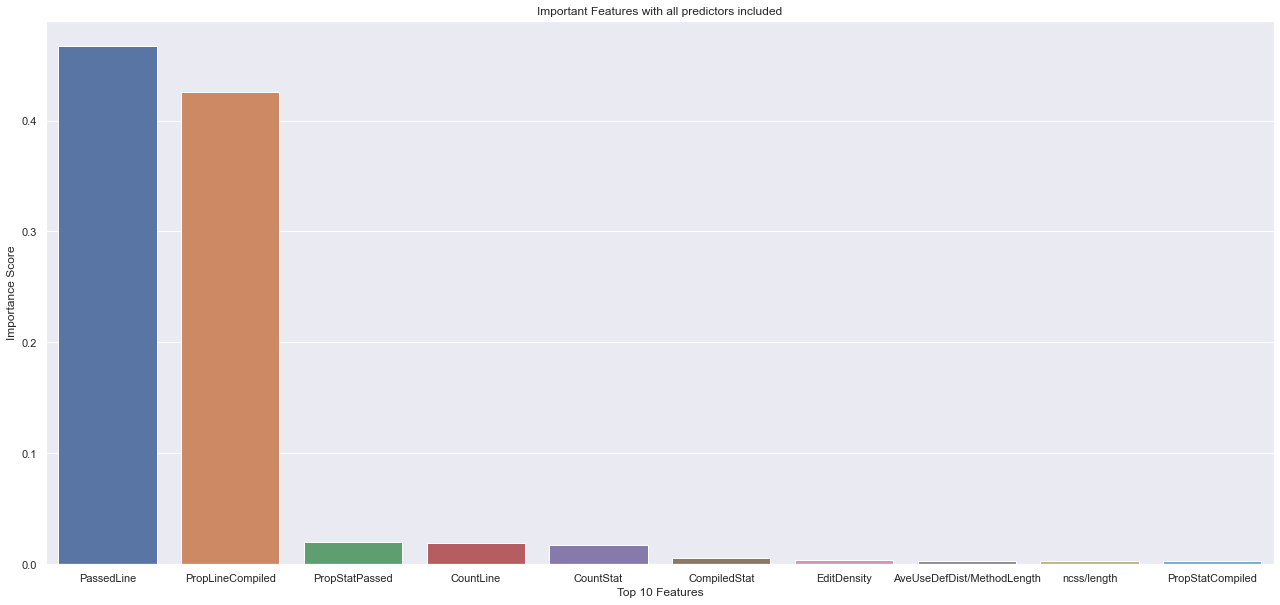

In [14]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (22, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features with all predictors included', xticklabels=top_10.index)

print(top_10)

## 5. Feature Selection

##### After getting the initial result with all features included, let's see what happens when we drop certain features, starting with PassedLine.

In [22]:
# Building a model with just the metrics
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)


(647, 14)
(278, 14)
(647,)
(278,)


#### P Value of X, y

In [23]:
p_value = calc_p_value(X, y)

print(p_value.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         PropLinePassed   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     7.130
Date:                Mon, 04 Apr 2022   Prob (F-statistic):           3.70e-14
Time:                        10:58:44   Log-Likelihood:                 860.88
No. Observations:                 925   AIC:                            -1692.
Df Residuals:                     910   BIC:                            -1619.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0428      0.019      2.202

#### P Value of X_train, y_train

In [24]:
p_value = calc_p_value(X_train, y_train)

print(p_value.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         PropLinePassed   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     5.279
Date:                Mon, 04 Apr 2022   Prob (F-statistic):           1.53e-09
Time:                        10:59:04   Log-Likelihood:                 612.85
No. Observations:                 647   AIC:                            -1196.
Df Residuals:                     632   BIC:                            -1129.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0482      0.022      2.146

ncss/length      0.171532
cyc/length       0.143981
AveUseDefDist    0.133129
npath/length     0.106433
ncss             0.100769
MedDefUseDist    0.086363
nestedIfs        0.047383
surfaceIfs       0.047335
npath            0.047204
cyclomatic       0.042275
dtype: float64


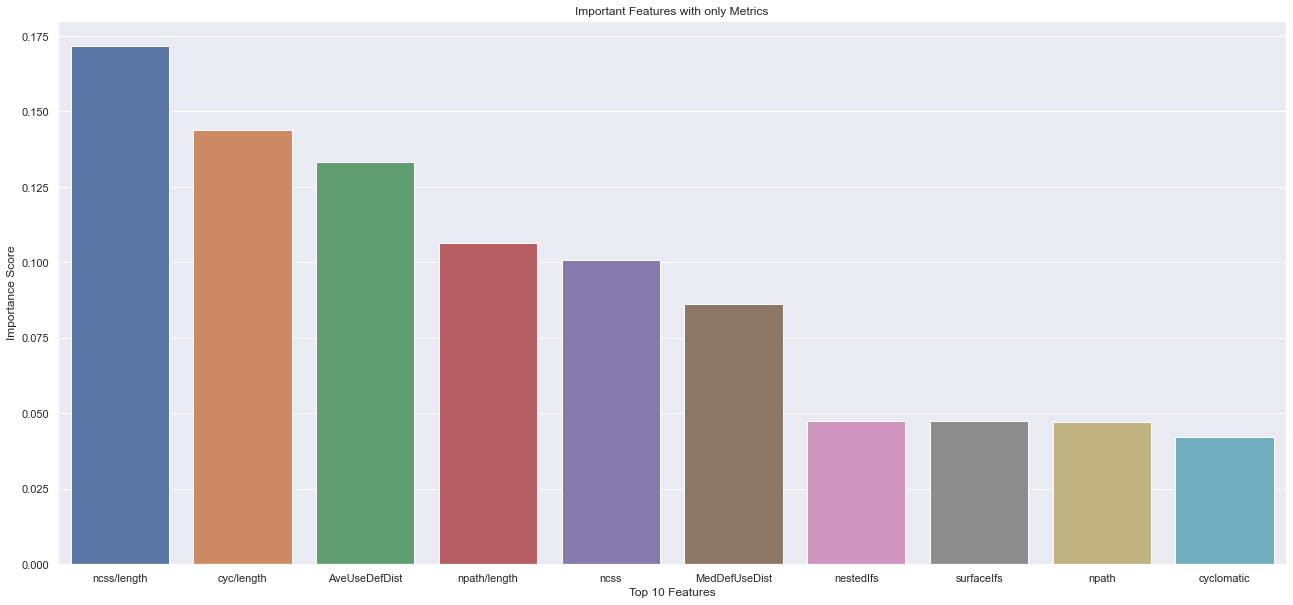

In [25]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (22, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features with only Checkstyle Metrics', xticklabels=top_10.index)

print(top_10)

In [26]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.05984
Adj. R2: 0.04493
RMSE: 0.02471
MAE: 0.12432


In [25]:
# Building a model with just the metrics
X = df_new[['surfaceFors', 'nestedFors', 'surfaceIfs', 'nestedIfs', 'surfaceWhiles', 'nestedWhiles', 'surfaceDos','nestedDos','surfaceSwitches','nestedSwitches']]


y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)


(647, 6)
(278, 6)
(647,)
(278,)


#### P Value of X, y

In [26]:
p_value = calc_p_value(X, y)

print(p_value.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         PropLinePassed   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     7.051
Date:                Mon, 04 Apr 2022   Prob (F-statistic):           2.36e-07
Time:                        10:59:27   Log-Likelihood:                 833.58
No. Observations:                 925   AIC:                            -1653.
Df Residuals:                     918   BIC:                            -1619.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1196      0.005     24.993

#### P Value of X_train, y_train

In [27]:
p_value = calc_p_value(X_train, y_train)

print(p_value.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         PropLinePassed   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     5.907
Date:                Mon, 04 Apr 2022   Prob (F-statistic):           5.14e-06
Time:                        10:59:42   Log-Likelihood:                 594.51
No. Observations:                 647   AIC:                            -1175.
Df Residuals:                     640   BIC:                            -1144.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1129      0.006     19.655

nestedIfs        0.339826
surfaceIfs       0.256124
surfaceFors      0.190286
nestedFors       0.147556
surfaceWhiles    0.037462
nestedWhiles     0.028745
dtype: float64


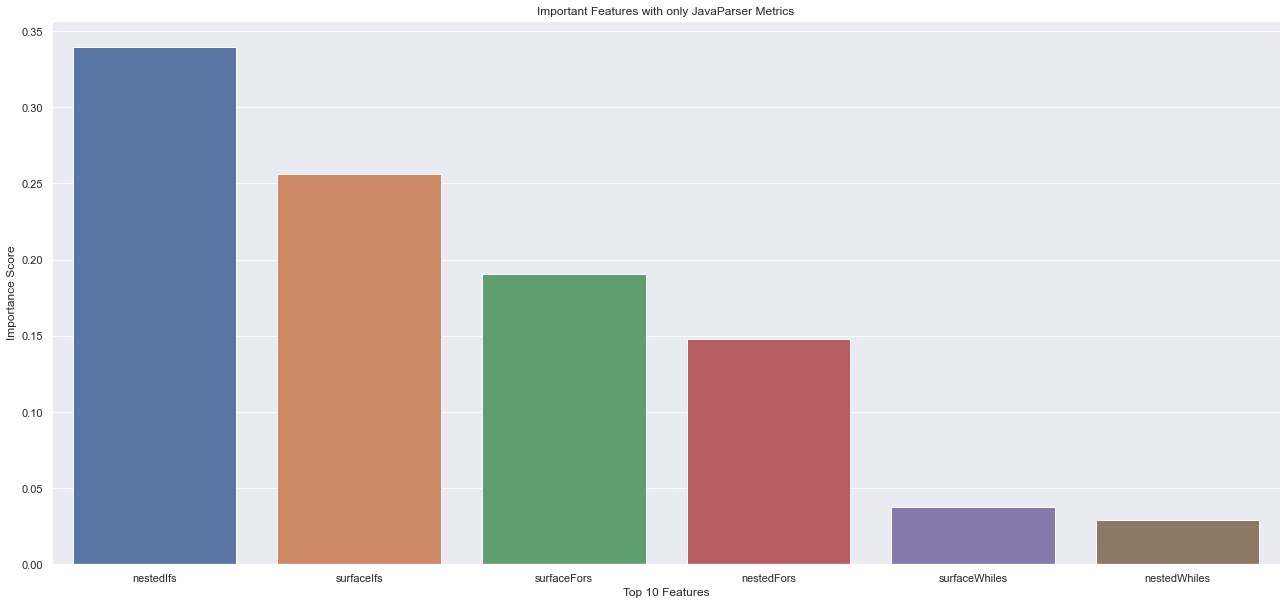

In [13]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (22, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features with only JavaParser Metrics', xticklabels=top_10.index)

print(top_10)

In [69]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.07188
Adj. R2: 0.06036
RMSE: 0.02440
MAE: 0.12385


## 6.1 Model Evaluation for model with JavaParser Metrics Only

### 6.1.1 Ridge Regression without Tuning

In [10]:
X = df_new[['surfaceFors', 'nestedFors', 'surfaceIfs', 'nestedIfs', 'surfaceWhiles', 'nestedWhiles', 'surfaceDos','nestedDos','surfaceSwitches','nestedSwitches']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
ridge = Ridge() 

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")


R2 Score: -0.01610
Adj. R2: -0.02722
RMSE: 0.02597
MAE: 0.12428


### 6.1.2 Ridge Regression with Tuning

In [11]:
X = df_new[['surfaceFors', 'nestedFors', 'surfaceIfs', 'nestedIfs', 'surfaceWhiles', 'nestedWhiles', 'surfaceDos','nestedDos','surfaceSwitches','nestedSwitches']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
ridge = Ridge()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create Search space
space = dict()

space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']

space['alpha'] = loguniform(1e-5, 100)

space['fit_intercept'] = [True, False]

space['normalize'] = [True, False]

# Define search
search = RandomizedSearchCV(ridge, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)

print('Best Hyperparameters: %s' % result.best_params_)

print(ridge.get_params())

Best Score: -0.11592059005126489
Best Hyperparameters: {'alpha': 0.18339906122816327, 'fit_intercept': True, 'normalize': True, 'solver': 'lsqr'}
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}


C:\Users\lj\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [12]:
ridge = Ridge(solver='lsqr', fit_intercept=True, normalize=False, alpha=0.18339906122816327)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: -0.01430
Adj. R2: -0.02540
RMSE: 0.02592
MAE: 0.12422


C:\Users\lj\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


### 6.2 KNN without Tuning

In [13]:
X = df_new[['surfaceFors', 'nestedFors', 'surfaceIfs', 'nestedIfs', 'surfaceWhiles', 'nestedWhiles', 'surfaceDos','nestedDos','surfaceSwitches','nestedSwitches']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
knnreg = KNeighborsRegressor()

knnreg.fit(X_train, y_train)

y_pred = knnreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: -0.09884
Adj. R2: -0.11087
RMSE: 0.02809
MAE: 0.13003


### 6.2.2 KNN with Tuning

In [38]:
X = df_new[['surfaceFors', 'nestedFors', 'surfaceIfs', 'nestedIfs', 'surfaceWhiles', 'nestedWhiles', 'surfaceDos','nestedDos','surfaceSwitches','nestedSwitches']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
knnreg = KNeighborsRegressor()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create Search space
space = dict()

space['algorithm'] = ['ball_tree', 'kd_tree', 'brute']

space['n_neighbors'] = [2, 3, 5, 10, 12, 15, 20, 25, 30]

space['weights'] = ['uniform', 'distance']

space['leaf_size'] = [10, 30, 60, 80, 160, 320]

space['p'] = [1, 2, 3]

# Define search
search = RandomizedSearchCV(knnreg, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)

print('Best Hyperparameters: %s' % result.best_params_)

C:\Users\lj\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 972 is smaller than n_iter=1000. Running 972 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Score: -0.07392226296915143
Best Hyperparameters: {'weights': 'uniform', 'p': 3, 'n_neighbors': 20, 'leaf_size': 320, 'algorithm': 'ball_tree'}


In [14]:
knnreg = KNeighborsRegressor(n_neighbors=20, weights='uniform', p=3, leaf_size=320, algorithm='ball_tree')

knnreg.fit(X_train, y_train)

y_pred = knnreg.predict(X_test)

r2 = r2_score(y_test, y_pred)
    
adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.02972
Adj. R2: 0.01910
RMSE: 0.02480
MAE: 0.12246


### 6.3.1 RandomForest without Tuning

In [15]:
X = df_new[['surfaceFors', 'nestedFors', 'surfaceIfs', 'nestedIfs', 'surfaceWhiles', 'nestedWhiles', 'surfaceDos','nestedDos','surfaceSwitches','nestedSwitches']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")
print(rforestreg.get_params())

R2 Score: -0.00093
Adj. R2: -0.01188
RMSE: 0.02558
MAE: 0.12529
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### 6.3.2 RandomForest with Tuning

In [24]:
X = df_new[['surfaceFors', 'nestedFors', 'surfaceIfs', 'nestedIfs', 'surfaceWhiles', 'nestedWhiles', 'surfaceDos','nestedDos','surfaceSwitches','nestedSwitches']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
rforestreg = RandomForestRegressor()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create Search space
space = dict()

space['n_estimators'] = [100, 250, 300, 350, 400, 450, 500]

space['bootstrap'] = [True, False]

space['warm_start'] = [True, False]

space['ccp_alpha'] = loguniform(1e-5, 100)

# Define search
search = RandomizedSearchCV(rforestreg, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)

print('Best Hyperparameters: %s' % result.best_params_)


Best Score: -0.11717826312330025
Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.00017114877263936507, 'n_estimators': 250, 'warm_start': True}


In [25]:
rforestreg = RandomForestRegressor(n_estimators = 250, warm_start=True, bootstrap=True, ccp_alpha=0.00017114877263936507)

rforestreg.fit(X_train, y_train)

y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.07215
Adj. R2: 0.06199
RMSE: 0.02372
MAE: 0.12064


### 6.4.1 MLPRegressor without Tuning

In [27]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropStatCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
mlpreg = MLPRegressor()

mlpreg.fit(X_train, y_train)

y_pred = mlpreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: -2.69076
Adj. R2: -2.72706
RMSE: 0.09791
MAE: 0.18597


### 6.4.2 MLPRegressor with Tuning

In [28]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropStatCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
mlpreg = MLPRegressor(max_iter=5500)

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create Search space
space = dict()

space['hidden_layer_sizes'] = [(50,50,50), (50,100,50), (100,1), (100, 50, 1)]

space['activation'] = ['relu', 'tanh', 'logistic']

space['alpha'] = loguniform(1e-5, 100)

space['learning_rate'] = ['constant', 'adaptive']

space['solver'] = ['adam', 'lbfgs']

# Define search
random_search = RandomizedSearchCV(mlpreg, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
random_search_result = random_search.fit(X_train, y_train)
                     
print('Random Search Best Score: %s' % random_search_result.best_score_)

print('Random Search Best Hyperparameters: %s' % random_search_result.best_params_)


Random Search Best Score: -0.122763735710209
Random Search Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.48777805499545607, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [29]:
mlpreg = MLPRegressor(activation='tanh', alpha=0.4877780549954560, hidden_layer_sizes=(50, 100, 50), learning_rate='adaptive', solver='adam')

mlpreg.fit(X_train, y_train)

y_pred = mlpreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.05907
Adj. R2: 0.04982
RMSE: 0.02496
MAE: 0.12566


C:\Users\lj\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
